# TensorFlow by example

https://github.com/INM-6/Python-Module-of-the-Week

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
plt.xkcd()
# In case there are font warnings: https://github.com/ipython/xkcd-font/blob/master/xkcd/build/xkcd.otf
# Setting the seeds to prevent things from breaking...
np.random.seed(42)
tf.set_random_seed(42)

## Part 1: A toy example

### Setup

Let's consider a toy 'neural network' consisting of two 'neurons' that map an input $x$ to an output $z$:
$$
y = f(w_1 x + b_1)
$$
$$
z = f(w_2 y + b_2)
$$
Here, $y$ is a vector (i.e. we have many 'hidden neurons'):
<img src="img/sketch.png" alt="sketch" width="200" align="middle"/>

For the nonlinearity, we use a sigmoid:
$$f(x) = 1 / (1 + e^{-x})$$

We want out network to approximate an arbitrary function $t(x)$. In principle, the above network should be able to do this with any precision according to the [universal approximation theorem](http://neuralnetworksanddeeplearning.com/chap4.html) - if we use enough hidden neurons.

For the loss, we use a simple quadratic loss: 
$$L = [z - t(x)]^2$$

### Computational Graph

In TensorFlow, we have to define the *computational graph* before doing any calculations. For our setup, we have this graph (created using TensorBoard):
<img src="img/graph.png" alt="drawing" width="700" align="middle"/>

Disclaimer: With [eager execution](https://www.tensorflow.org/tutorials/eager/eager_basics) the above is not strictly true anymore.

### TensorFlow implementation

In [3]:
num_hidden = 5                        # number of hidden neurons
x_linspace = np.linspace(0, 1, 100)   # some input values

# A placeholder for the input (batch size unknown)
x = tf.placeholder(tf.float32, [None, 1], name='x')

# Our hidden neurons
w1 = tf.Variable(tf.random_normal([1, num_hidden], stddev=.1), name='w1')
b1 = tf.Variable(tf.random_normal([num_hidden], stddev=.1), name='b1')
y = tf.sigmoid(tf.add(tf.matmul(x, w1), b1))

# The output neuron
w2 = tf.Variable(tf.random_normal([num_hidden, 1], stddev=.1), name='w2')
b2 = tf.Variable(tf.random_normal([1], stddev=.1), name='b2')
z = tf.sigmoid(tf.add(tf.matmul(y, w2), b2))

# Execute the graph
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    z_out = sess.run(z, feed_dict={x: x_linspace[:, np.newaxis]})

### Let's have a look

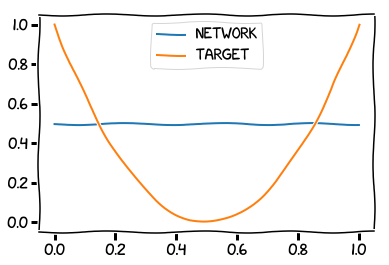

In [4]:
def target_funct(x):
    return 4*(x - 0.5)**2  # our target function
    # return 0.5*np.sin(4*np.pi*x) + 0.5  # our target function

# Plot network output against target function
plt.plot(x_linspace, z_out, label='NETWORK')
plt.plot(x_linspace, target_funct(x_linspace), label='TARGET')
plt.legend()

### Backprop

Now we want to optimize. To do so, we need the derivatives of the loss $L = [z - t(x)]^2$ wrt. the parameters $w_1, b_1, w_2, b_2$. Let's start with the bias of our output neuron $z = f(w_2 y + b_2)$:

$$
\frac{dL}{db_2} = \frac{\partial L}{\partial z}\frac{dz}{db_2} = \frac{\partial L}{\partial z} f^\prime(w_2 y + b_2)
$$

with $\frac{\partial L}{\partial z} = 2[z - t(x)]$. From the forward pass we know $y$ and $z$ so the expression can be evaluated. Now the weights:

$$
\frac{dL}{dw_2} = \frac{\partial L}{\partial z}\frac{dz}{dw_2} = \frac{dL}{db_2} y
$$

Neat - we don't need to compute anything here because we know $\frac{dL}{db_2}$ already! Finally:

$$
\frac{dL}{db_1} = \frac{\partial L}{\partial z}\frac{\partial z}{\partial y}\frac{dy}{db_1} = \frac{dL}{db_2} w_2f^\prime(w_1 x + b_1) \\
\frac{dL}{dw_1} = \frac{\partial L}{\partial z}\frac{\partial z}{\partial y}\frac{dy}{dw_1} = \frac{dL}{db_1} x
$$

Of course with more layers we could play this game ad infinitum. The nice part here is that many operations can be parallelized.

### Optimization

That's all there is - backprop is just the chain rule and a clever strategy to compute it. A few notes:
* The name is pretty obvious: We go backwards along the computational graph here.
* We see a problem on the horizon: Any vanishing term in the products above make them vanish entirely
  * e.g. when $f^\prime(\dots) \approx 0$ for the saturated sigmoid -> ReLu's
  * e.g. when the weights are initialized too small or too big -> Xavier init
* The main purpose (afaik) of TensorFlow is to automate the calculation of the derivatives and distribute them optimally.

The dénouement is the update of the parameters along the gradient, e.g.
$$
w_1 = w_1 - \lambda \frac{dL}{dw_1}
$$
where $\lambda$ is the learning rate. Of course, there plenty of better schemes than this vanilla gradient descent. Again, a few notes:
* The loss function is not convex, i.e. there are in most cases plenty of local optima / saddle points
* Because it is non-convex, a simple gradient descent would get stuck in a local minimum -> SGD, Adam, ...
* The learning rate is crucial: If it is too large you get lost (could even diverge), if it is too small you never arrive

### Training the model

In [5]:
learning_rate = 1e-2   # learning rate
epochs = int(3e3)      # number of epochs
batch_size = 128       # batch size

# target and loss
target = tf.placeholder(tf.float32, [None, 1], name='target')
loss = tf.reduce_mean(tf.square(z - target))

# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    loss_storage = np.empty(epochs)
    # iterate 'epochs'
    for epoch in range(epochs):
        # generate samples
        batch_x = np.random.rand(batch_size)
        batch_target = target_funct(batch_x)
        # calculate loss and execute train_op
        _, loss_storage[epoch] = sess.run(
            [train_op, loss], feed_dict={
                x: batch_x[:, np.newaxis], 
                target: batch_target[:, np.newaxis]})
    # generate prediction
    z_out = sess.run(z, feed_dict={x: x_linspace[:, np.newaxis]})

### Loss

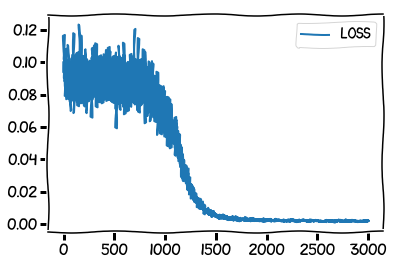

In [6]:
plt.plot(loss_storage, label='LOSS')
plt.legend(loc=0)

### Let's have a look

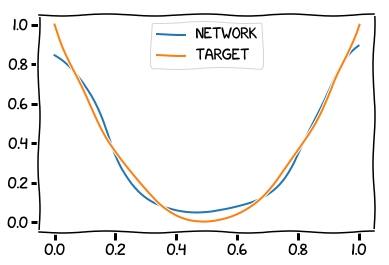

In [7]:
plt.plot(x_linspace, z_out, label='NETWORK')
plt.plot(x_linspace, target_funct(x_linspace), label='TARGET')
plt.legend(loc=0)

## Part 2: MNIST - what else?

In [8]:
# clear the tensorflow graph
tf.reset_default_graph()

### Setup

Essentially, we use the same architecture as above. Differences:
* $28 \times 28 = 784$ inputs instead of a single one
* $10$ output neurons for the ten digits
* $300$ hidden neurons
* `relu` (hidden) and `softmax` (output) nonlinearity
* We use another optimizer
* We use another loss function (cross entropy)

Basically this is a concise code-only example without all the annoying text.

Let's start by getting the data:

In [9]:
# tensorflow.examples.tutorials.mnist is deprecated
# Because it is useful we just suppress the warnings...
old_tf_verbosity = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)

In [10]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [11]:
# ... and restore the warnings again
tf.logging.set_verbosity(old_tf_verbosity)

### Building the model

In [12]:
# input placeholder - for 28 x 28 pixels = 784
x = tf.placeholder(tf.float32, [None, 784])
# label placeholder - 10 digits
y = tf.placeholder(tf.float32, [None, 10])

# hidden layer
w1 = tf.Variable(tf.random_normal([784, 300], stddev=0.03), name='w1')
b1 = tf.Variable(tf.random_normal([300]), name='b1')
hidden_out = tf.nn.relu(tf.add(tf.matmul(x, w1), b1))

# output layer
w2 = tf.Variable(tf.random_normal([300, 10], stddev=0.03), name='w2')
b2 = tf.Variable(tf.random_normal([10]), name='b2')
y_ = tf.nn.softmax(tf.add(tf.matmul(hidden_out, w2), b2))

### Setting up the optimization

In [13]:
learning_rate = 0.5

# loss function
y_clipped = tf.clip_by_value(y_, 1e-10, 0.9999999)  # needed for logarithm
cross_entropy = -tf.reduce_mean(tf.reduce_sum(
    y * tf.log(y_clipped) + (1 - y) * tf.log(1 - y_clipped), axis=1))

# optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(cross_entropy)

# accuracy
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Running it

In [14]:
epochs = 10
batch_size = 128

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    total_batch = int(len(mnist.train.labels) / batch_size)
    loss_storage = np.empty(epochs)
    for epoch in range(epochs):
        avg_loss = 0.
        for i in range(total_batch):
            batch_x, batch_y = mnist.train.next_batch(batch_size=batch_size)
            _, batch_loss = sess.run([train_op, cross_entropy], 
                                     feed_dict={x: batch_x, y: batch_y})
            avg_loss += batch_loss / total_batch
        loss_storage[epoch] = avg_loss
    final_acc = sess.run(accuracy, feed_dict={
        x: mnist.test.images, y: mnist.test.labels})

### Let's have a look

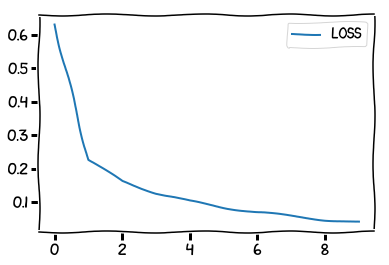

In [15]:
plt.plot(loss_storage, label='LOSS')
plt.legend(loc=0)

In [16]:
print("Final accuracy: {:.1f}%".format(100*final_acc))

Final accuracy: 97.8%


## References

* Strongly influenced by this [Python TensorFlow Tutorial](http://adventuresinmachinelearning.com/python-tensorflow-tutorial/)
* [A high-bias, low-variance introduction to Machine Learning for physicists](https://arxiv.org/abs/1803.08823) 
* The [CS231n](http://cs231n.github.io) Stanford class
* The [Neural Networks and Deep Learning](http://www.neuralnetworksanddeeplearning.com) online book